In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
# from train_bbnet import get_args, load_model
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def zscore(x, eps=1e-6):
    m = x.mean((-2,-1), True)
    s = x.std((-2,-1), True)
    return (x - m) / s.clamp(min=eps)

def get_patches(im, radius=1):
    if radius == 0:
        return im
    shape = im.shape
    if len(shape) == 5:
        im = im.view(shape[0]*shape[1], *shape[2:])
    B,C,H,W = im.shape
    
    im = F.pad(im, (radius, radius, radius, radius))
    k = 2*radius+1
    im = F.unfold(im, (k, k)).view(-1,C*(k**2),H,W)
    if len(shape) == 5:
        im = im.view(shape[0], shape[1], *im.shape[1:])
    return im    
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = (aff_node.shape[-1] - 1) // 2
#     aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,(K+1):]], 1)        
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False, is_test=False, sigmoid=True):
    dataset.is_test = is_test
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = (nn.Sigmoid() if sigmoid else nn.Identity())(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  
    

def viz_boundary_preds(b_preds, thresh=0.1, max_speed=0.1, do_plot=True):
    motion = None
    if b_preds.shape[1] == 9:
        c1_preds, b_preds, c2_preds = b_preds.split([4,1,4], dim=-3)
        c_preds = torch.cat([c1_preds, c2_preds], -3).softmax(-3)
        c_preds_rgb = fprop.circular_target_to_spatial_moment(c_preds)
    elif b_preds.shape[1] == 3:
        b_preds, c_preds = b_preds.split([1,2], dim=-3)
        c_preds_rgb = c_preds
    elif b_preds.shape[1] == 4:
        motion, b_preds, c_preds = b_preds.split([1,1,2], dim=-3)
        c_preds_rgb = c_preds
    b_preds = b_preds.sigmoid()
    if do_plot:
        vis_utils.imshow(data_utils.FlowToRgb(max_speed=max_speed)(c_preds_rgb) * (b_preds > thresh).float())    
    return (b_preds, c_preds, motion)


def get_boundary_preds(model, dataset, ex, static_input=True, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]
    if backward:
        ups_mask, b_preds = model(img2, img2 if static_input else img1, test_mode=True, iters=iters)
    else:
        ups_mask, b_preds = model(img1, img1 if static_input else img2, test_mode=True, iters=iters)
    return (b_preds, ups_mask)

def get_motion_preds(model, dataset, ex, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]    
    if backward:
        ups_mask, m_preds = model(img2, img2, test_mode=True, iters=iters)
    else:
        ups_mask, m_preds = model(img1, img2, test_mode=True, iters=iters)
    return (m_preds, ups_mask)

def get_boundary_movie(model, dataset, ex, iters=12, thresh=None):
    img1, img2, img0 = [x[None].cuda() for x in dataset[ex][:3]]
    b1 = model(img1, img1, test_mode=True, iters=12)[-1]
    b2 = model(img2, img2, test_mode=True, iters=12)[-1]
    b0 = model(img0, img0, test_mode=True, iters=12)[-1]
    b_movie = []
    for b in [b0, b1, b2]:
        b_preds, c_preds = viz_boundary_preds(b, do_plot=False)
        if thresh is not None:
            b_movie.append((b_preds > thresh).float() * c_preds)
        else:
            b_movie.append(b_preds * c_preds)
    return torch.stack(b_movie, 1)

def get_video(dataset, ex=0, stride=1):
    dataset.get_backward_frame = True
    data = dataset[ex]
    if dataset.T == 3:
        video = torch.stack([x.cuda() for x in [data[2], data[0], data[1]]], 0) / 255.
    elif dataset.T == 2:
         video = torch.stack([x.cuda() for x in [data[0], data[1]]], 0) / 255.        
    size = list(video.shape[-2:])
    if stride > 1:
        video = transforms.Resize((size[0] // stride, size[1] // stride))(video)
    return video[None]

import matplotlib
def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class DatasetV2(collections.Iterable, tracking_base.Trackable,
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resource

In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(5)],
    split='validation',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)


data_dir = '/mnt/fs6/honglinc/dataset/tensorflow_datasets/movi_e/256x256/1.0.0'
movi_dataset = raft_datasets.MoviFlowDataset(
    root=data_dir,
    split='validation',
    sequence_length=2
)
print(len(movi_dataset))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


625
True
250


## Evaluate flow-trained models

In [47]:
import teachers
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*bmt*rnd0*movi_d*gs1*
flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd1*movi_d*gs1*

# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*tdw*bs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd1*tdw*

flow_paths = sorted(flow_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(flow_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-pretrained-0.pth
1 ../checkpoints/2500_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-scratch-0.pth
2 ../checkpoints/5000_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-pretrained-0.pth
3 ../checkpoints/5000_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-scratch-0.pth
4 ../checkpoints/7500_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-scratch-0.pth
5 ../checkpoints/10000_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-scratch-0.pth
6 ../checkpoints/12500_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-scratch-0.pth


In [57]:
f_idx = 2
flow_net = teachers.load_model(
    load_path=flow_paths[f_idx],
    model_class='flow',
    parse_path=True,
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> RAFT ../checkpoints/5000_flowBoundary-rnd1-movi_d-bs2-large-mt05-bt01-gs1-pretrained-0.pth


In [50]:
# boundary_paths = !ls ../checkpoints/[0-9]*boundary*rnd1*dtarg*fullplay*pretrained*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*cthr075*fullplay*rerun*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*small*nthr0*cthr075*fullplay*
# boundary_paths = !ls ../checkpoints/100000*boundaryMotionReg*rnd0*small*nthr0*fullplay*

boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotion*rnd0*movi_d*nthr0-*gs1*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStatic*rnd0*movi_d*nthr0-*gs1*

boundary_paths = sorted(boundary_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
for i,p in enumerate(boundary_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-0.pth
1 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-1.pth
2 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-2.pth
3 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth
4 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-0.pth
5 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-1.pth
6 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-2.pth
7 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth
8 ../checkpoints/7500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-0.pth
9 ../checkpoints/7500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-1.pth
10 ../checkpoints/7500_boundaryMotionReg

In [52]:
b_idx = -1
b_net = teachers.load_model(
    load_path=boundary_paths[b_idx],
    model_class='boundary',
    parse_path=True
).cuda()

<All keys matched successfully> BoundaryClassifier ../checkpoints/100000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
ex = 0
tdw_dataset.get_gt_flow = True
tdw_dataset.get_backward_frame = False
tdw_dataset.is_test = True
dataset = tdw_dataset

img1, img2, flow = [x[None].cuda() for x in dataset[ex][:3]]
_, flow_pred = flow_net(img1, img2, test_mode=True, iters=12)
b_preds = teachers.MotionToStaticTeacher.get_boundary_preds(b_net, img1, img2)
b, c = b_preds[:2]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


movie, frame b'4970' 21


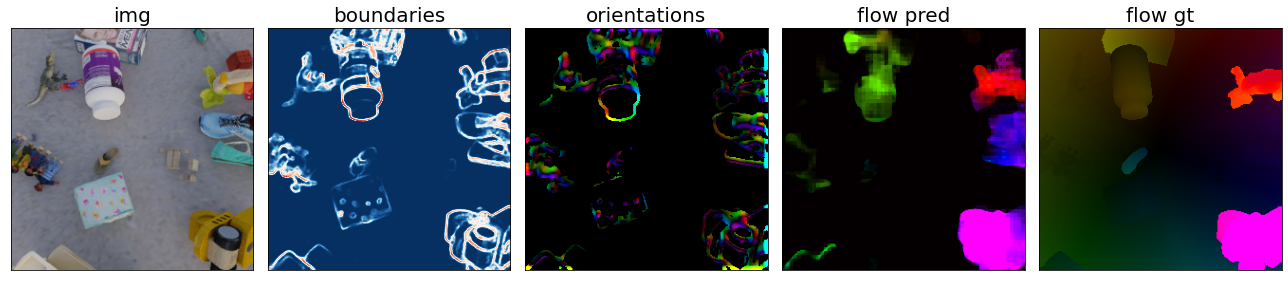

In [92]:
def plot_boundary_flows(flow_net, boundary_net, dataset, ex, max_speed=3.0, max_gt_speed=50., mask_pred=True,
                        flip_gt=True,
                        boundary_thresh=0.1, flow_iters=12, boundary_iters=12):
    img1, img2, flow_gt = [x[None].cuda() for x in dataset[ex][:3]]
    flow_pred, _ = teachers.MotionToStaticTeacher.get_flow_preds(
        flow_net, img1, img2, iters=flow_iters, resolution=None)
    b_preds = teachers.MotionToStaticTeacher.get_boundary_preds(boundary_net, img1, img2, iters=boundary_iters)
    b, c = b_preds[:2]
    b_mask = (b > boundary_thresh).float()
    if flip_gt:
        flow_gt = torch.stack([-flow_gt[:,1], flow_gt[:,0]], 1)

    plots = [
        img1 / 255.,
        b*2 - 1,
        data_utils.FlowToRgb(0.25)(c) * b_mask,
        data_utils.FlowToRgb(max_speed)(flow_pred) * (b_mask if mask_pred else 1),
        data_utils.FlowToRgb(max_gt_speed)(flow_gt)
    ]
    titles = ['img', 'boundaries', 'orientations', 'flow pred', 'flow gt']
    assert len(plots) == len(titles)
    n_cols = len(plots)
    fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols-2, 4))
    for i, ax in enumerate(axes):
        vis_utils.imshow(plots[i], ax, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=20)
    plt.tight_layout()
    plt.show()
    
    return {
        'image': img1,
        'boundaries': b,
        'orientations': c,
        'flow_pred': flow_pred,
        'flow_gt': flow_gt
    }
    
ex = 5100
tdw_dataset.is_test = False
dataset = movi_dataset
preds = plot_boundary_flows(flow_net, b_net, dataset, ex=ex, mask_pred=False, 
                        flip_gt=False, flow_iters=24,
                        max_speed=0.5, 
                        max_gt_speed=5.0)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


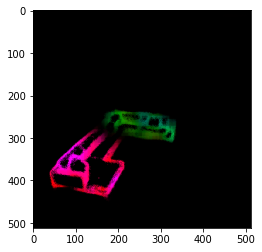

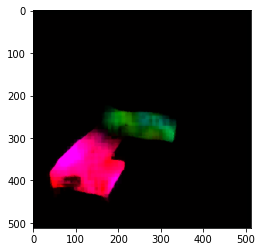

In [68]:
vis_utils.imshow(data_utils.FlowToRgb(1.0)(flow_pred) * (b > 0.1).float())
vis_utils.imshow(data_utils.FlowToRgb(1.0)(flow_pred))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


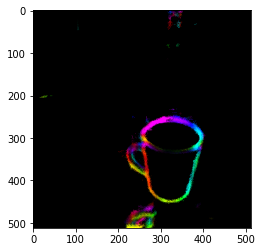

In [68]:
vis_utils.imshow(data_utils.FlowToRgb(0.25)(c) * (b > 0.1).float())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


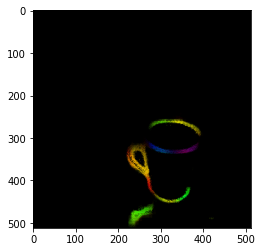

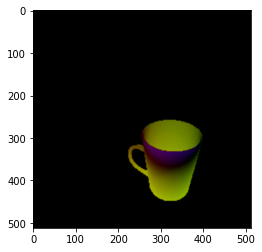

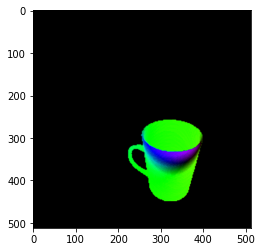

In [69]:
# flow_pred = torch.stack([flow_pred[:,1], flow_pred[:,0]], 1)
b_mask = (b > 0.1).float()
vis_utils.imshow(b_mask * data_utils.FlowToRgb(3.0)(flow_pred))
_flow = torch.stack([-flow[:,1], flow[:,0]], 1)
vis_utils.imshow(data_utils.FlowToRgb(50.)(_flow))
vis_utils.imshow(torch.tensor(flow_to_rgb(_flow[0].cpu().permute(1,2,0).numpy())).permute(2,0,1)[None])


## Now try the teacher version

In [6]:
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr05*fullplay*pretrained*
motion_paths = !ls ../checkpoints/[0-9]*motion*tdw*nthr0-cthr025*
# motion_paths = !ls ../checkpoints/[0-9]*motion*movi_d*nthr0-*gs1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-rerun.pth
1 ../checkpoints/5000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth
2 ../checkpoints/5000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
3 ../checkpoints/10000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth
4 ../checkpoints/10000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
5 ../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth
6 ../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
7 ../checkpoints/20000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
8 ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth


In [7]:
# boundary_paths = !ls ../checkpoints/[0-9]*boundary*rnd1*dtarg*fullplay*pretrained*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*cthr075*fullplay*rerun*
boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*small*nthr0*cthr075*fullplay*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*large*nthr0*fullplay*

# boundary_paths = !ls ../checkpoints/[0-9]*boundary*rnd0*movi_d*nthr0-*gs1*

boundary_paths = sorted(boundary_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
for i,p in enumerate(boundary_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/5000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall-ctd.pth
1 ../checkpoints/5000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
2 ../checkpoints/5000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall-rerun.pth
3 ../checkpoints/10000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall-ctd.pth
4 ../checkpoints/10000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
5 ../checkpoints/10000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall-rerun.pth
6 ../checkpoints/15000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall-ctd.pth
7 ../checkpoints/15000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
8 ../checkpoints/15000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall-rerun.pth
9 ../checkpoints/20000_bound

In [8]:
import teachers
m_idx = -1
b_idx = -1
m_path = motion_paths[m_idx]
b_path = boundary_paths[b_idx]

TargetFunc = teachers.FuturePredictionTeacher(
    downsample_factor=2,
    concat_rgb_features=False,
    concat_motion_features=False,
    concat_boundary_features=True,
    concat_orientation_features=True,
    concat_fire_features=False,
    motion_path=m_path,
    boundary_path=b_path,
    motion_model_params={
        'small': 'small' in m_path,
        'gate_stride': 2 if ('gs1' not in m_path) else 1
    },
    boundary_model_params={
        'small': 'small' in b_path,
        'static_input': 'Static' in b_path,
        'orientation_type': 'regression',
        'gate_stride': 2 if ('gs1' not in b_path) else 1
    }
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
<All keys matched successfully> BoundaryClassifier ../checkpoints/70000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall-rerun.pth


In [19]:
ex = 0
dataset = tdw_dataset
data = dataset[ex]
img1, img2 = [x[None].cuda() for x in data[:2]]
target = TargetFunc(img1, img2)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[autoreload of train failed: Traceback (most recent call last):
  File "/home/dbear/tenv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/dbear/tenv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/dbear/tenv/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/dbear/tenv/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


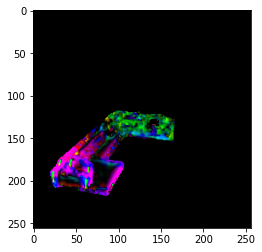

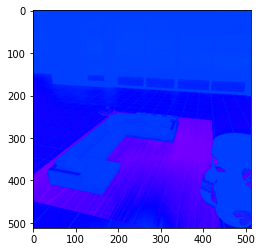

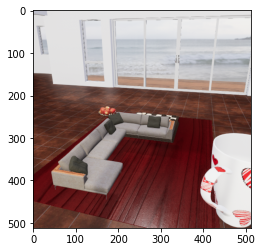

In [20]:
vis_utils.imshow(data_utils.FlowToRgb(3., from_sampling_grid=True)(target))
flow = torch.tensor(flow_to_rgb(data[2].permute(1,2,0).numpy())).permute(2,0,1)[None]
vis_utils.imshow(flow)
vis_utils.imshow(img1 / 255.)

In [12]:
target.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 2, 256, 256])